# landscraper - doing the dirty work for intellectual property (IP) decisions

__Contributer: Akhil Jindal__ | https://github.com/akhil-jindal/

## Library Imports:

In [1]:
from sklearn.datasets import *
from sklearn import model_selection
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
import scikitplot as skplt
from sklearn import metrics

from glob import glob
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import re

import os

## Building a pipeline

In [2]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None)),
])

## Identifying and processing training inputs:

In [3]:
corpus = "../data/corpus/"
patents = load_files(corpus)
classifications = patents.target_names

## Split training data:

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    patents.data, patents.target, train_size = 0.7)

/usr/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Training and testing a model:

In [5]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        st...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [6]:
prediction = pipeline.predict(X_test)

In [7]:
np.mean(prediction == y_test)

0.6699029126213593

## Adding Stop Words:

In [8]:
def add_stopwords():
    """added some custom stop words that are commonly found in patent applications and 
    should not be considered when training a document.
    """
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    ps = PorterStemmer()
    addl_stop_words = ["\\n", "according", "accordingly", "aforementioned", "al", "another", "apparatus", 
                   "aspect", "composed", "comprising", "consisting", "device", "disclose", "disclosed",
                   "disclosure", "drawing", "elements", "embodiment", "et", "features", "FIG", "Figures", 
                   "first", "fourth", "furthermore", "herein", "hereby", "least", "nearly", "plurality", 
                   "prior", "respective", "scope", "second", "similar", "substantially", "thereof", "third", 
                   "U.S.", "U.S.C", "via", "accordance", "hereinafter", "illustrative", "spirit", "finally"]
    for word in addl_stop_words:
        stop_words.add(word)
        
    for word in addl_stop_words:
        lem_word = lemmatizer.lemmatize(word)
        stop_words.add(lem_word)
        
    for word in addl_stop_words:
        stem_word = ps.stem(word)
        stop_words.add(stem_word)
        
    return stop_words

In [9]:
stop_words = add_stopwords()

In [10]:
pipeline_sw = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_words)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None)),
])

In [11]:
pipeline_sw.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=set([u'a...ty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [12]:
prediction_sw = pipeline_sw.predict(X_test)

In [13]:
np.mean(prediction_sw == y_test)

0.6763754045307443

## Tuning Parameters via Grid Search:

In [ ]:
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (1e-2, 1e-4, 1e-6),
    'clf__penalty': ('l2', 'elasticnet'),
}

In [ ]:
gs_clf = GridSearchCV(pipeline_sw, parameters, cv=5, iid=False, n_jobs=-1)

In [ ]:
gs_clf = gs_clf.fit(X_train, y_train)

In [ ]:
gs_clf.best_score_

In [ ]:
gs_clf.best_params_

In [15]:
pipeline_best = Pipeline([
    ('vect', CountVectorizer(max_df=0.5, ngram_range=(1,2), stop_words=stop_words)),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('clf', SGDClassifier(loss='hinge', penalty='elasticnet',
                           alpha=0.0001, random_state=42,
                           max_iter=5, tol=None)),
])

In [16]:
pipeline_best.fit(X_train, y_train)
prediction_best = pipeline_best.predict(X_test)
np.mean(prediction_best == y_test)

0.6634304207119741

## Visualizing scikit-learn Results:

In [18]:
cv_prediction = cross_val_predict(pipeline, X_test, y_test)
cv_prediction_sw = cross_val_predict(pipeline_sw, X_test, y_test)
cv_prediction_best = cross_val_predict(pipeline_best, X_test, y_test)

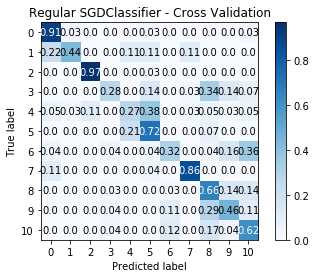

In [19]:
skplt.metrics.plot_confusion_matrix(y_test, cv_prediction, normalize=True)
plt.title("Regular SGDClassifier - Cross Validation")
plt.show()

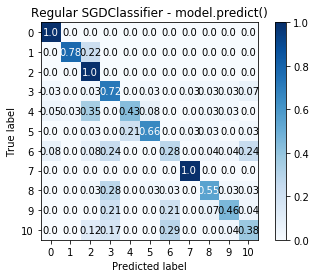

In [21]:
skplt.metrics.plot_confusion_matrix(y_test, prediction, normalize=True)
plt.title("Regular SGDClassifier - model.predict()")
plt.show()

In [24]:
print(metrics.classification_report(y_test, cv_prediction, target_names=classifications))

             precision    recall  f1-score   support

       G06C       0.80      0.91      0.85        35
       G06D       0.67      0.44      0.53         9
       G06E       0.90      0.97      0.93        36
       G06F       0.67      0.28      0.39        29
       G06G       0.59      0.27      0.37        37
       G06J       0.48      0.72      0.58        29
       G06K       0.53      0.32      0.40        25
       G06M       0.89      0.86      0.87        28
       G06N       0.41      0.66      0.51        29
       G06Q       0.48      0.46      0.47        28
       G06T       0.42      0.62      0.50        24

avg / total       0.63      0.61      0.60       309



In [25]:
print(metrics.classification_report(y_test, prediction, target_names=classifications))

             precision    recall  f1-score   support

       G06C       0.88      1.00      0.93        35
       G06D       0.88      0.78      0.82         9
       G06E       0.61      1.00      0.76        36
       G06F       0.47      0.72      0.57        29
       G06G       0.73      0.43      0.54        37
       G06J       0.79      0.66      0.72        29
       G06K       0.33      0.28      0.30        25
       G06M       0.93      1.00      0.97        28
       G06N       0.73      0.55      0.63        29
       G06Q       0.72      0.46      0.57        28
       G06T       0.45      0.38      0.41        24

avg / total       0.68      0.67      0.66       309



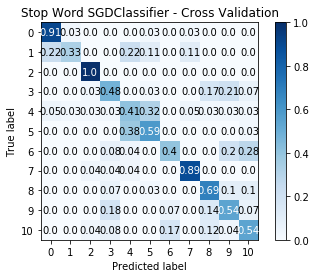

In [26]:
skplt.metrics.plot_confusion_matrix(y_test, cv_prediction_sw, normalize=True)
plt.title("Stop Word SGDClassifier - Cross Validation")
plt.show()

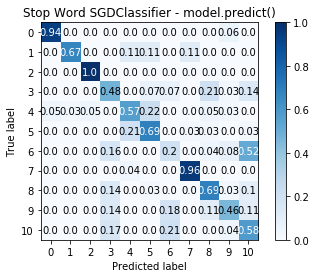

In [27]:
skplt.metrics.plot_confusion_matrix(y_test, prediction_sw, normalize=True)
plt.title("Stop Word SGDClassifier - model.predict()")
plt.show()

In [28]:
print(metrics.classification_report(y_test, cv_prediction_sw, target_names=classifications))

             precision    recall  f1-score   support

       G06C       0.89      0.91      0.90        35
       G06D       0.60      0.33      0.43         9
       G06E       0.90      1.00      0.95        36
       G06F       0.52      0.48      0.50        29
       G06G       0.50      0.41      0.45        37
       G06J       0.52      0.59      0.55        29
       G06K       0.62      0.40      0.49        25
       G06M       0.86      0.89      0.88        28
       G06N       0.61      0.69      0.65        29
       G06Q       0.48      0.54      0.51        28
       G06T       0.45      0.54      0.49        24

avg / total       0.64      0.65      0.64       309



In [29]:
print(metrics.classification_report(y_test, prediction_sw, target_names=classifications))

             precision    recall  f1-score   support

       G06C       0.94      0.94      0.94        35
       G06D       0.86      0.67      0.75         9
       G06E       0.95      1.00      0.97        36
       G06F       0.47      0.48      0.47        29
       G06G       0.72      0.57      0.64        37
       G06J       0.62      0.69      0.66        29
       G06K       0.29      0.20      0.24        25
       G06M       0.93      0.96      0.95        28
       G06N       0.61      0.69      0.65        29
       G06Q       0.62      0.46      0.53        28
       G06T       0.37      0.58      0.45        24

avg / total       0.68      0.68      0.67       309



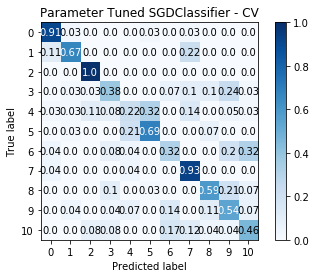

In [30]:
skplt.metrics.plot_confusion_matrix(y_test, cv_prediction_best, normalize=True)
plt.title("Parameter Tuned SGDClassifier - CV")
plt.show()

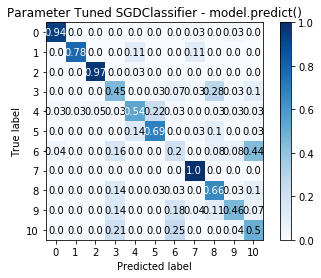

In [31]:
skplt.metrics.plot_confusion_matrix(y_test, prediction_best, normalize=True)
plt.title("Parameter Tuned SGDClassifier - model.predict()")
plt.show()

In [32]:
print(metrics.classification_report(y_test, cv_prediction_best, target_names=classifications))

             precision    recall  f1-score   support

       G06C       0.89      0.91      0.90        35
       G06D       0.55      0.67      0.60         9
       G06E       0.84      1.00      0.91        36
       G06F       0.50      0.38      0.43        29
       G06G       0.44      0.22      0.29        37
       G06J       0.59      0.69      0.63        29
       G06K       0.44      0.32      0.37        25
       G06M       0.65      0.93      0.76        28
       G06N       0.65      0.59      0.62        29
       G06Q       0.42      0.54      0.47        28
       G06T       0.44      0.46      0.45        24

avg / total       0.60      0.61      0.60       309



In [33]:
print(metrics.classification_report(y_test, prediction_best, target_names=classifications))

             precision    recall  f1-score   support

       G06C       0.94      0.94      0.94        35
       G06D       0.88      0.78      0.82         9
       G06E       0.95      0.97      0.96        36
       G06F       0.42      0.45      0.43        29
       G06G       0.77      0.54      0.63        37
       G06J       0.67      0.69      0.68        29
       G06K       0.25      0.20      0.22        25
       G06M       0.85      1.00      0.92        28
       G06N       0.53      0.66      0.58        29
       G06Q       0.65      0.46      0.54        28
       G06T       0.36      0.50      0.42        24

avg / total       0.67      0.66      0.66       309



## Exporting the Models:

In [34]:
import pickle

In [35]:
with open("../pickles/model_1", "wb") as f:
    pickle.dump(pipeline,f)

In [36]:
with open("../pickles/model_2", "wb") as f:
    pickle.dump(pipeline_sw,f)

In [37]:
with open("../pickles/model_3", "wb") as f:
    pickle.dump(pipeline_best,f)